In [1]:
import torch

In [41]:
# Создадим даталоадеры на основе датасетов MNIST/CIFAR

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader 

In [7]:
# class FCN 
import torch.nn as nn
import json


class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()
        
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs
        
        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)
        
        self.layers = self._build_layers()
    
    def load_config(self, config_path):
        """Загружает конфигурацию из JSON файла"""
        with open(config_path, 'r') as f:
            return json.load(f)
    
    def _build_layers(self):
        layers = []
        prev_size = self.input_size
        
        layer_config = self.config.get('layers', [])
        
        for layer_spec in layer_config:
            layer_type = layer_spec['type']
            
            if layer_type == 'linear':
                out_size = layer_spec['size']
                layers.append(nn.Linear(prev_size, out_size))
                prev_size = out_size
                
            elif layer_type == 'relu':
                layers.append(nn.ReLU())
                
            elif layer_type == 'sigmoid':
                layers.append(nn.Sigmoid())
                
            elif layer_type == 'tanh':
                layers.append(nn.Tanh())
                
            elif layer_type == 'dropout':
                rate = layer_spec.get('rate', 0.5)
                layers.append(nn.Dropout(rate))
                
            elif layer_type == 'batch_norm':
                layers.append(nn.BatchNorm1d(prev_size))
                
            elif layer_type == 'layer_norm':
                layers.append(nn.LayerNorm(prev_size))
        
        layers.append(nn.Linear(prev_size, self.num_classes))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)


def create_model_from_config(config_path, input_size=None, num_classes=None):
    """Создает модель из JSON конфигурации"""
    return FullyConnectedModel(config_path, input_size, num_classes) 

# 1.1 Сравнение моделей разной глубины (15 баллов)


In [70]:
# Создайте и обучите модели с различным количеством слоев: (Создадим для классификации MNIST)

# - 1 слой (линейный классификатор)
config1layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": []}
model1layer = FullyConnectedModel(**config1layer)

# - 2 слоя (1 скрытый)
config2layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 512}]}
model2layer = FullyConnectedModel(**config2layer)

# - 3 слоя (2 скрытых)
config3layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 512},
               {'type': 'linear', 'size': 256},
               {'type': 'relu'}]}
model3layer = FullyConnectedModel(**config3layer)

# - 5 слоев (4 скрытых)
config5layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "linear", "size": 128},
        {"type": "relu"}
    ]
} 
model5layer = FullyConnectedModel(**config5layer)

# - 7 слоев (6 скрытых)
config7layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "linear", "size": 400},
        {"type": "relu"},
        {"type": "linear", "size": 300},
        {"type": "relu"},
        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "linear", "size": 128},
        {"type": "relu"}
    ]
}
model7layer = FullyConnectedModel(**config7layer)


In [331]:
# trainer 
import torch.optim as optim
from tqdm import tqdm


def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False, l2_alpha=0.001):
    if is_test:
        model.eval()
    else:
        model.train()
    
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # print(f'Epoch {epoch+1}/{epochs}:')
        # print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        # print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        # print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 


In [92]:
loss_accs = {}
models = {'layer1': model1layer, 
          'layer2': model2layer,
          'layer3': model3layer, 
          'layer5 ': model5layer, 
          'layer7':model7layer}

train_loader, test_loader = get_mnist_loaders()
device = torch.device('cuda')

for model_name in models.keys():
    model = models[model_name]
    model = model.to(device)
    loss_accs[model_name] = train_model(model, train_loader, test_loader, epochs=10, device=device)
    print(loss_accs[model_name])
    

# Для каждого варианта:
# - Сравните точность на train и test
# - Визуализируйте кривые обучения
# - Проанализируйте время обучения

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.33it/s]


Epoch 1/10:
Train Loss: 0.2833, Train Acc: 0.9206
Test Loss: 0.2754, Test Acc: 0.9229
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.38it/s]


Epoch 2/10:
Train Loss: 0.2755, Train Acc: 0.9222
Test Loss: 0.2683, Test Acc: 0.9240
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 61.10it/s]


Epoch 3/10:
Train Loss: 0.2714, Train Acc: 0.9247
Test Loss: 0.2783, Test Acc: 0.9233
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 61.69it/s]


Epoch 4/10:
Train Loss: 0.2678, Train Acc: 0.9251
Test Loss: 0.2767, Test Acc: 0.9233
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 61.83it/s]


Epoch 5/10:
Train Loss: 0.2659, Train Acc: 0.9254
Test Loss: 0.2749, Test Acc: 0.9242
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 61.22it/s]


Epoch 6/10:
Train Loss: 0.2622, Train Acc: 0.9266
Test Loss: 0.2692, Test Acc: 0.9264
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 60.57it/s]


Epoch 7/10:
Train Loss: 0.2616, Train Acc: 0.9274
Test Loss: 0.2943, Test Acc: 0.9154
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 60.78it/s]


Epoch 8/10:
Train Loss: 0.2608, Train Acc: 0.9278
Test Loss: 0.2815, Test Acc: 0.9216
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 62.37it/s]


Epoch 9/10:
Train Loss: 0.2592, Train Acc: 0.9282
Test Loss: 0.2728, Test Acc: 0.9250
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 60.13it/s]


Epoch 10/10:
Train Loss: 0.2565, Train Acc: 0.9282
Test Loss: 0.2767, Test Acc: 0.9258
--------------------------------------------------
{'train_losses': [0.2832687633282849, 0.2755146624444962, 0.2714081647188297, 0.26783868855139464, 0.2658666086190545, 0.26218899462554757, 0.26162166936374676, 0.26080177090506057, 0.25918838648256587, 0.2564909883907863], 'train_accs': [0.9205666666666666, 0.9222333333333333, 0.9247, 0.9250666666666667, 0.92545, 0.9265833333333333, 0.9273833333333333, 0.9277666666666666, 0.9282333333333334, 0.9282166666666667], 'test_losses': [0.2753892029178845, 0.2683358333981151, 0.27833239314187863, 0.27669596020132303, 0.27494707054630585, 0.26915251158154124, 0.29434592593579917, 0.2815436872232492, 0.2728136687889505, 0.276705800175999], 'test_accs': [0.9229, 0.924, 0.9233, 0.9233, 0.9242, 0.9264, 0.9154, 0.9216, 0.925, 0.9258]}


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 53.17it/s]


Epoch 1/10:
Train Loss: 0.3507, Train Acc: 0.9000
Test Loss: 0.3205, Test Acc: 0.9088
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 58.83it/s]


Epoch 2/10:
Train Loss: 0.3277, Train Acc: 0.9063
Test Loss: 0.3525, Test Acc: 0.8973
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.04it/s]


Epoch 3/10:
Train Loss: 0.3180, Train Acc: 0.9099
Test Loss: 0.2991, Test Acc: 0.9143
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.25it/s]


Epoch 4/10:
Train Loss: 0.3072, Train Acc: 0.9135
Test Loss: 0.2913, Test Acc: 0.9159
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 66.13it/s]


Epoch 5/10:
Train Loss: 0.3003, Train Acc: 0.9152
Test Loss: 0.2984, Test Acc: 0.9172
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.69it/s]


Epoch 6/10:
Train Loss: 0.2970, Train Acc: 0.9173
Test Loss: 0.3054, Test Acc: 0.9138
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.66it/s]


Epoch 7/10:
Train Loss: 0.2934, Train Acc: 0.9173
Test Loss: 0.2882, Test Acc: 0.9178
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.06it/s]


Epoch 8/10:
Train Loss: 0.2899, Train Acc: 0.9180
Test Loss: 0.3182, Test Acc: 0.9119
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.46it/s]


Epoch 9/10:
Train Loss: 0.2891, Train Acc: 0.9186
Test Loss: 0.3065, Test Acc: 0.9102
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.34it/s]


Epoch 10/10:
Train Loss: 0.2829, Train Acc: 0.9211
Test Loss: 0.2931, Test Acc: 0.9192
--------------------------------------------------
{'train_losses': [0.3506782412417789, 0.3276837289031508, 0.3179662814224834, 0.30721740286821114, 0.3003158425249016, 0.29699353238682885, 0.29336295098161647, 0.28989644045991175, 0.2890556577855209, 0.2829112968187152], 'train_accs': [0.8999833333333334, 0.9063333333333333, 0.9099333333333334, 0.9135333333333333, 0.9152, 0.9172833333333333, 0.9173166666666667, 0.91795, 0.9185833333333333, 0.9211333333333334], 'test_losses': [0.3205264279868003, 0.35249912758968815, 0.2991233133550757, 0.29128970550432515, 0.2983842480180275, 0.305419254098918, 0.2881853264537017, 0.3182197547262641, 0.3065033457508892, 0.2930790746442167], 'test_accs': [0.9088, 0.8973, 0.9143, 0.9159, 0.9172, 0.9138, 0.9178, 0.9119, 0.9102, 0.9192]}


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 58.93it/s]


Epoch 1/10:
Train Loss: 0.2370, Train Acc: 0.9281
Test Loss: 0.1324, Test Acc: 0.9591
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 62.30it/s]


Epoch 2/10:
Train Loss: 0.1260, Train Acc: 0.9617
Test Loss: 0.1056, Test Acc: 0.9671
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 55.75it/s]


Epoch 3/10:
Train Loss: 0.1082, Train Acc: 0.9678
Test Loss: 0.1188, Test Acc: 0.9664
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.23it/s]


Epoch 4/10:
Train Loss: 0.0952, Train Acc: 0.9717
Test Loss: 0.1254, Test Acc: 0.9691
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.19it/s]


Epoch 5/10:
Train Loss: 0.0879, Train Acc: 0.9743
Test Loss: 0.1008, Test Acc: 0.9726
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.46it/s]


Epoch 6/10:
Train Loss: 0.0791, Train Acc: 0.9767
Test Loss: 0.1237, Test Acc: 0.9707
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 60.98it/s]


Epoch 7/10:
Train Loss: 0.0787, Train Acc: 0.9777
Test Loss: 0.1389, Test Acc: 0.9685
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.29it/s]


Epoch 8/10:
Train Loss: 0.0793, Train Acc: 0.9776
Test Loss: 0.1430, Test Acc: 0.9705
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.97it/s]


Epoch 9/10:
Train Loss: 0.0730, Train Acc: 0.9800
Test Loss: 0.1296, Test Acc: 0.9704
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 58.84it/s]


Epoch 10/10:
Train Loss: 0.0702, Train Acc: 0.9809
Test Loss: 0.1586, Test Acc: 0.9707
--------------------------------------------------
{'train_losses': [0.23699543353166186, 0.12604271777436885, 0.10820801837443272, 0.09521542882808903, 0.08788389491922866, 0.07909063325043389, 0.07866763296030235, 0.0793299855769742, 0.07298314294417953, 0.070159570632449], 'train_accs': [0.9281, 0.9616833333333333, 0.9678, 0.97165, 0.9742666666666666, 0.9766666666666667, 0.9777, 0.9776, 0.9800166666666666, 0.9809], 'test_losses': [0.1324018249540311, 0.10563283654784036, 0.11879566470387237, 0.12540982451138719, 0.10077648865341529, 0.12365941539096088, 0.13894838142310897, 0.1430237607755159, 0.12957577176598678, 0.15855774232692912], 'test_accs': [0.9591, 0.9671, 0.9664, 0.9691, 0.9726, 0.9707, 0.9685, 0.9705, 0.9704, 0.9707]}


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.38it/s]


Epoch 1/10:
Train Loss: 0.2383, Train Acc: 0.9267
Test Loss: 0.1480, Test Acc: 0.9555
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.51it/s]


Epoch 2/10:
Train Loss: 0.1031, Train Acc: 0.9690
Test Loss: 0.0936, Test Acc: 0.9743
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.24it/s]


Epoch 3/10:
Train Loss: 0.0747, Train Acc: 0.9772
Test Loss: 0.1163, Test Acc: 0.9670
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.20it/s]


Epoch 4/10:
Train Loss: 0.0590, Train Acc: 0.9826
Test Loss: 0.0912, Test Acc: 0.9741
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.51it/s]


Epoch 5/10:
Train Loss: 0.0505, Train Acc: 0.9851
Test Loss: 0.0908, Test Acc: 0.9762
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 57.97it/s]


Epoch 6/10:
Train Loss: 0.0407, Train Acc: 0.9875
Test Loss: 0.0828, Test Acc: 0.9781
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 53.64it/s]


Epoch 7/10:
Train Loss: 0.0359, Train Acc: 0.9895
Test Loss: 0.1061, Test Acc: 0.9768
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 57.55it/s]


Epoch 8/10:
Train Loss: 0.0350, Train Acc: 0.9901
Test Loss: 0.0860, Test Acc: 0.9782
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 58.45it/s]


Epoch 9/10:
Train Loss: 0.0281, Train Acc: 0.9918
Test Loss: 0.1171, Test Acc: 0.9748
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.06it/s]


Epoch 10/10:
Train Loss: 0.0267, Train Acc: 0.9922
Test Loss: 0.0812, Test Acc: 0.9817
--------------------------------------------------
{'train_losses': [0.23829968902530638, 0.10307813912797878, 0.07465640674638095, 0.05896516052533442, 0.05052459721991133, 0.040692915768870935, 0.035934251520446, 0.034965100444840955, 0.02814053024708873, 0.02665358749192222], 'train_accs': [0.92675, 0.9690166666666666, 0.9771666666666666, 0.9825833333333334, 0.9850666666666666, 0.9874833333333334, 0.98945, 0.9901166666666666, 0.99175, 0.9921666666666666], 'test_losses': [0.14803380167681227, 0.09362171552891793, 0.11632207758349491, 0.09115258138626814, 0.09082054533854525, 0.08279908111839826, 0.10612854686865877, 0.0859725615513653, 0.11712164883788695, 0.08115152659319361], 'test_accs': [0.9555, 0.9743, 0.967, 0.9741, 0.9762, 0.9781, 0.9768, 0.9782, 0.9748, 0.9817]}


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.32it/s]


Epoch 1/10:
Train Loss: 0.2779, Train Acc: 0.9152
Test Loss: 0.1848, Test Acc: 0.9448
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.85it/s]


Epoch 2/10:
Train Loss: 0.1175, Train Acc: 0.9669
Test Loss: 0.1161, Test Acc: 0.9662
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 55.93it/s]


Epoch 3/10:
Train Loss: 0.0906, Train Acc: 0.9752
Test Loss: 0.1098, Test Acc: 0.9718
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 57.39it/s]


Epoch 4/10:
Train Loss: 0.0764, Train Acc: 0.9790
Test Loss: 0.1009, Test Acc: 0.9742
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 53.33it/s]


Epoch 5/10:
Train Loss: 0.0614, Train Acc: 0.9832
Test Loss: 0.0954, Test Acc: 0.9778
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.11it/s]


Epoch 6/10:
Train Loss: 0.0544, Train Acc: 0.9851
Test Loss: 0.0748, Test Acc: 0.9795
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.07it/s]


Epoch 7/10:
Train Loss: 0.0453, Train Acc: 0.9877
Test Loss: 0.1022, Test Acc: 0.9775
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 59.39it/s]


Epoch 8/10:
Train Loss: 0.0410, Train Acc: 0.9886
Test Loss: 0.0795, Test Acc: 0.9790
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 57.40it/s]


Epoch 9/10:
Train Loss: 0.0374, Train Acc: 0.9901
Test Loss: 0.1330, Test Acc: 0.9709
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 61.25it/s]

Epoch 10/10:
Train Loss: 0.0325, Train Acc: 0.9908
Test Loss: 0.1002, Test Acc: 0.9805
--------------------------------------------------
{'train_losses': [0.27790250742176514, 0.11752993498009437, 0.09061570123653673, 0.07636572659744927, 0.061375115898242696, 0.05435108514645992, 0.04534386145621181, 0.041018183623120485, 0.037389015339937104, 0.032544515009658326], 'train_accs': [0.9151833333333333, 0.9669333333333333, 0.9751666666666666, 0.9789833333333333, 0.9832333333333333, 0.9851, 0.9877, 0.9886333333333334, 0.9900666666666667, 0.9908166666666667], 'test_losses': [0.18481824781662623, 0.11608942949389564, 0.10982135177702475, 0.10092687558910697, 0.0954499424076591, 0.07479092280711692, 0.10215774745766709, 0.07953119725145115, 0.1330458700149103, 0.10019428994687037], 'test_accs': [0.9448, 0.9662, 0.9718, 0.9742, 0.9778, 0.9795, 0.9775, 0.979, 0.9709, 0.9805]}


In [190]:
# Сохраним полученные результаты
torch.save(loss_accs, 'loss_accuracy.pt')

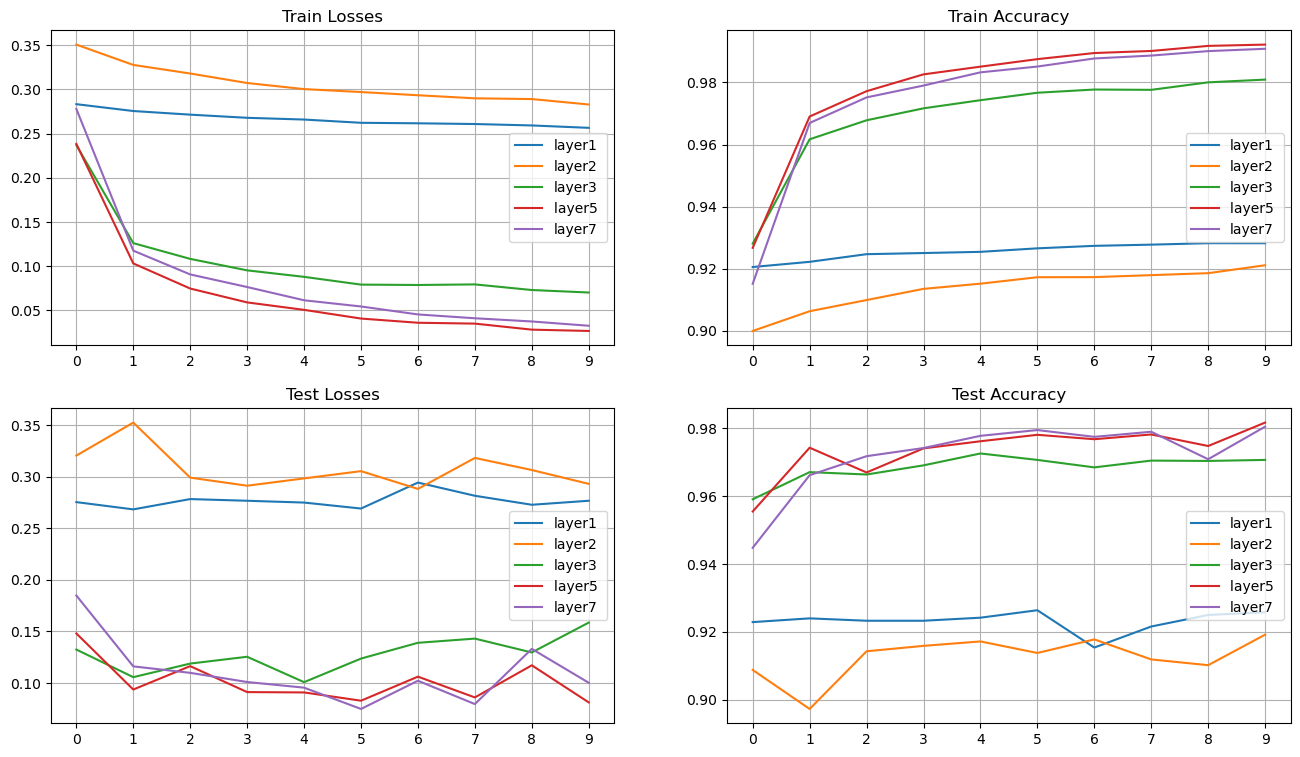

In [176]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize=(16, 9))

for k, values in loss_accs.items():
    for i, val in enumerate(values.values()):
        nrow = i // 2
        ncol = i % 2
        ax[nrow, ncol].plot(val, label=k)
        ax[nrow, ncol].legend()
        ax[nrow, ncol].grid(True)
        ax[nrow, ncol].set_xticks(range(10))

ax[0, 0].set_title('Train Losses')
ax[0, 1].set_title('Train Accuracy')
ax[1, 0].set_title('Test Losses')
ax[1, 1].set_title('Test Accuracy')

plt.show()


Для каждого варианта:
- Сравните точность на train и test
> Точность на test всегда немного ниже, чем на train. Связано это с тем, что модель "запоминает" значения из train выборки.
- Визуализируйте кривые обучения
> Заметил, что графики на тестовых выборках более ломанные, чем на тренировочной. Опять же это проявление "запоминания" значений признаков 
- Проанализируйте время обучения
> Чем больше слоев, тем больше параметров, которые нужно изменить. Отсюда скорость обучения снижается

## 1.2 Анализ переобучения (15 баллов)


In [202]:
# Исследуйте влияние глубины на переобучение:
# Прожолдим обучение модели с 5 слоями на 60 эпох:
model = model5layer.to(device)
total_epochs70_loss_accr = train_model(model, train_loader, test_loader, epochs=60, device=device)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [19:31<00:00, 19.52s/it]


In [204]:
# Сохраним полученные значения losses/accuracy
torch.save(total_epochs70_loss_accr, 'loss70.pt')

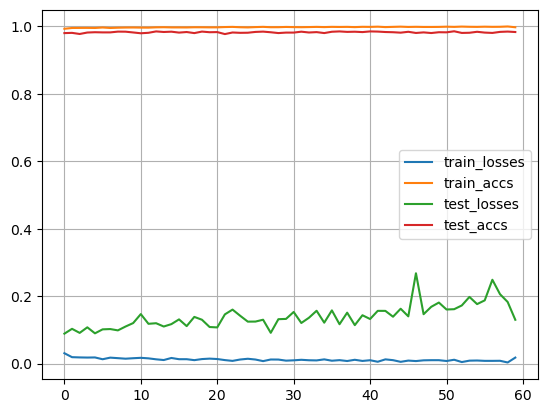

In [220]:
# - Постройте графики train/test accuracy по эпохам
for key, val in total_epochs70_loss_accr.items():
    plt.plot(val, label=k)
plt.legend(total_epochs70_loss_accr.keys())
plt.grid(True)
plt.show()

In [224]:
# - Добавьте Dropout и BatchNorm, сравните результаты
configDropBatchNorm3layer ={
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 512},
               {'type': 'dropout', 'rate': 0.3},
               {'type': 'batch_norm'},
               {'type': 'linear', 'size': 256},
               {'type': 'relu'}]}
model3layerDropNorm = FullyConnectedModel(**configDropBatchNorm3layer)
model3layerDropNorm = model3layerDropNorm.to(device)
loss_accr_with_DropNorm_60epochs = train_model(model3layerDropNorm, train_loader, test_loader, epochs=60, device=device)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [20:08<00:00, 20.13s/it]


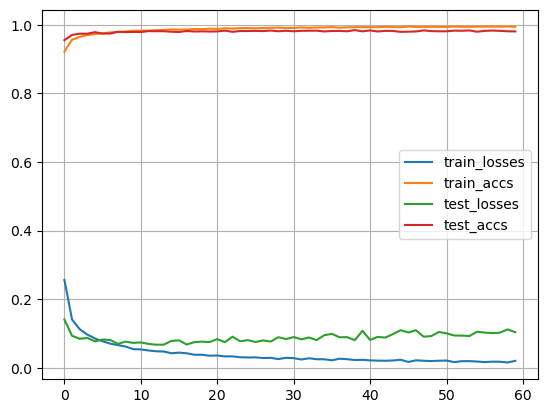

In [227]:
for key, val in loss_accr_with_DropNorm_60epochs.items():
    plt.plot(val, label=k)
plt.legend(total_epochs70_loss_accr.keys())
plt.grid(True)
plt.show()

- Проанализируйте, когда начинается переобучение
> У модели с 5 слоями не очень видно, но график после 40 эпох **test_losses** начинает немного подниматься вверх, что говорит о начале переобучении
> У модели с dropout and BatchNorm график остается таким же, но скорость наростания уже примерно меньше в **2 раза** 
 - Определите оптимальную глубину для каждого датасета
> Для обычной с 5 слоями - около 30, с Dropout/BatchNorm - около 40, но можно также оставить 30

# Задание 2: Эксперименты с шириной сети (25 баллов)


## 2.1 Сравнение моделей разной ширины (15 баллов)


In [274]:
# Создайте модели с различной шириной слоев:
# Для каждого варианта Поддерживайте одинаковую глубину (3 слоя)
# - Узкие слои: [64, 32, 16]
slim = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 64},
               {'type': 'relu'},
               {'type': 'linear', 'size': 32},
               {'type': 'relu'},
               {'type':' linear', 'size': 16}]}

# - Средние слои: [256, 128, 64]
medium = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 256},
               {'type': 'relu'},
               {'type': 'linear', 'size': 128},
               {'type': 'relu'},
               {'type':' linear', 'size': 64}]}

# - Широкие слои: [1024, 512, 256]
wide = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 1024},
               {'type': 'relu'},
               {'type': 'linear', 'size': 512},
               {'type': 'relu'},
               {'type':' linear','size': 256}]}

# - Очень широкие слои: [2048, 1024, 512]
huge = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 2048},
               {'type': 'relu'},
               {'type': 'linear', 'size': 1024},
               {'type': 'relu'},
               {'type':' linear','size': 512}]}


slim_model = FullyConnectedModel(**slim)
medium_model = FullyConnectedModel(**medium)
wide_model = FullyConnectedModel(**wide)
huge_model = FullyConnectedModel(**huge)

models_dict = {
    'slim':slim_model,
    'medium': medium_model,
    'wide': wide_model,
    'huge': huge_model
}



In [276]:
import time
losses_many_layers = {}
c=10
total_time = []
for name in models_dict:
    model = models_dict[name]
    model = model.to(device)
    start = time.time()
    losses_many_layers[name] = train_model(model, train_loader, test_loader, epochs=c, device=device)
    tmp_time = time.time() - start
    total_time.append(tmp_time)
    print(f'{name} layer|  Total time: {tmp_time}')

torch.save(losses_many_layers, 'many_layers.pt')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.35s/it]


slim layer|  Total time: 153.45590138435364


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.58s/it]


medium layer|  Total time: 165.79324078559875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.30s/it]


wide layer|  Total time: 202.9603831768036


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:02<00:00, 18.26s/it]

huge layer|  Total time: 182.5820653438568


Model slim layer: 52650 parametrs. Time: 153.46 sec
Model medium layer: 235146 parametrs. Time: 165.79 sec
Model wide layer: 1333770 parametrs. Time: 202.96 sec
Model huge layer: 3716106 parametrs. Time: 182.58 sec


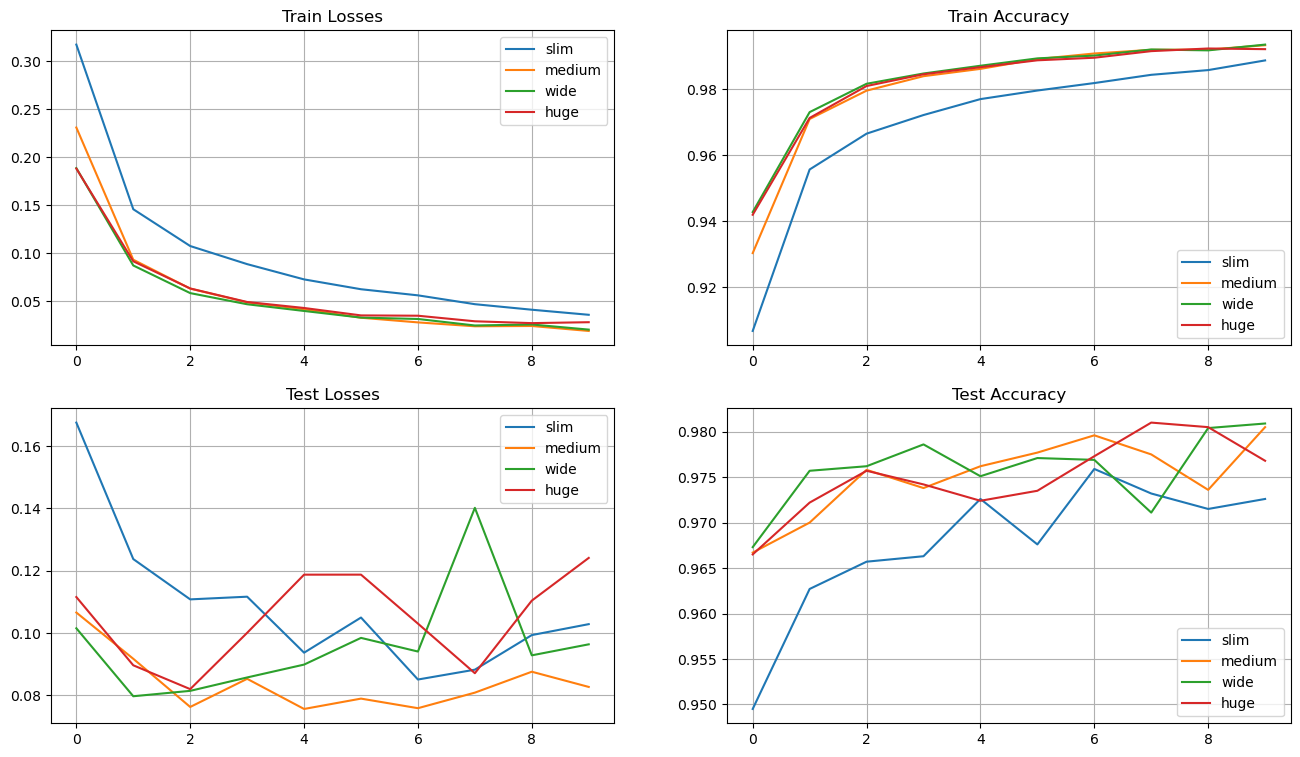

In [288]:
# - Проанализируйте количество параметров
def count_parameters(model):
    """Подсчитывает количество параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for i, m in enumerate(models_dict.keys()):
    print(f'Model {m} layer: {count_parameters(models_dict[m])} parametrs. Time: {total_time[i]:.2f} sec')

#### - Сравните точность и время обучения
fig, ax = plt.subplots(2,2, figsize=(16, 9))

for k, values in losses_many_layers.items():
    for i, val in enumerate(values.values()):
        nrow = i // 2
        ncol = i % 2
        ax[nrow, ncol].plot(val, label=k)
        ax[nrow, ncol].legend()
        ax[nrow, ncol].grid(True)

ax[0, 0].set_title('Train Losses')
ax[0, 1].set_title('Train Accuracy')
ax[1, 0].set_title('Test Losses')
ax[1, 1].set_title('Test Accuracy')

plt.show()



Здесь самая оптимальная **medium сеть**: всего 235146 параметров и достаточна стабильна.\
Losses/Accuracy примерно такое же, как и у *Wide, Huge моделей*

## 2.2 Оптимизация архитектуры (10 баллов)


In [ ]:
# Найдите оптимальную архитектуру:
# - Используйте grid search для поиска лучшей комбинации
# - Попробуйте различные схемы изменения ширины (расширение, сужение, постоянная)
# - Визуализируйте результаты в виде heatmap

# Задание 3: Эксперименты с регуляризацией (25 баллов)


## 3.1 Сравнение техник регуляризации (15 баллов)


In [299]:
# Исследуйте различные техники регуляризации:
# Для каждого варианта:
# - Используйте одинаковую архитектуру

# - Без регуляризации
usual = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 256},
               {'type': 'relu'},
               {'type': 'linear', 'size': 128},
               {'type': 'relu'},
               {'type':' linear', 'size': 64}]}

usual_model = FullyConnectedModel(**usual)

# - Только Dropout (разные коэффициенты: 0.1, 0.3, 0.5)
only_dropout = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 256},
               {'type': 'dropout', 'rate': 0.1},
               {'type': 'relu'},
               {'type': 'linear', 'size': 128},
               {'type': 'dropout', 'rate': 0.3},
               {'type': 'relu'},
               {'type':' linear', 'size': 64},
               {'type': 'dropout', 'rate': 0.5}]}
dropout_model = FullyConnectedModel(**only_dropout)

# - Только BatchNorm
only_batchNorm = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 256},
               {'type': 'batch_norm'},
               {'type': 'relu'},
               {'type': 'linear', 'size': 128},
               {'type': 'batch_norm'},
               {'type': 'relu'},
               {'type':' linear', 'size': 64},
               {'type': 'batch_norm'}]}
batchNorm_model = FullyConnectedModel(**only_batchNorm)

# - Dropout + BatchNorm
dropout_batchNorm =  {
    "input_size": 784,
    "num_classes": 10,
    "layers": [{"type": "linear", "size": 256},
               {'type': 'batch_norm'},
               {'type': 'dropout', 'rate': 0.1},
               {'type': 'relu'},
               {'type': 'linear', 'size': 128},
               {'type': 'batch_norm'},
               {'type': 'dropout', 'rate': 0.3},
               {'type': 'relu'},
               {'type':' linear', 'size': 64},
               {'type': 'batch_norm'},
               {'type': 'dropout', 'rate': 0.5}]}
dropbatch_model = FullyConnectedModel(**dropout_batchNorm)

search_models = {
    'usual' : usual_model,
    'dropout': dropout_model,
    'dropout_batchnorm': dropbatch_model,
    'batchNorm' : batchNorm_model}

In [345]:
search_loss = {}
for model_name in search_models.keys():
    model = search_models[model_name]
    model = model.to(device)
    search_loss[model_name] = train_model(model, train_loader, test_loader, epochs=10, device=device)
    print(search_loss[model_name])



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.53s/it]


{'train_losses': [0.0205592986057377, 0.015116321987461599, 0.018174273192125296, 0.013864708940614976, 0.013003671344720207, 0.01797751012745934, 0.01348395457119941, 0.012102679227405667, 0.013208327971094024, 0.009701018188501852], 'train_accs': [0.9933333333333333, 0.9949, 0.9940166666666667, 0.9956166666666667, 0.9957666666666667, 0.9944833333333334, 0.9955833333333334, 0.9963166666666666, 0.9959, 0.99685], 'test_losses': [0.0927413432161887, 0.09537523340327932, 0.08389375693848827, 0.09233314090566942, 0.1067779133404131, 0.08660422108747373, 0.09752648730805802, 0.10003397199104067, 0.12165730529974432, 0.10968915116145167], 'test_accs': [0.9813, 0.9792, 0.9807, 0.979, 0.9808, 0.9815, 0.9795, 0.9803, 0.9785, 0.9781]}


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:49<00:00, 16.98s/it]


{'train_losses': [0.0911077082587549, 0.07518552376408139, 0.07343647543969911, 0.06914524565739279, 0.06553129470452412, 0.06277945912330782, 0.058457831734791896, 0.052776284521939096, 0.055050490939497466, 0.04925134644778108], 'train_accs': [0.9741333333333333, 0.9780666666666666, 0.97875, 0.9802, 0.9805333333333334, 0.9825333333333334, 0.9825, 0.9839166666666667, 0.9830333333333333, 0.9851833333333333], 'test_losses': [0.09022316903360227, 0.0916985975288594, 0.08407551486016597, 0.08918520640659269, 0.08706450223627697, 0.09843735126011031, 0.0893092682830241, 0.08770536552040056, 0.0776439115576181, 0.08397852946337295], 'test_accs': [0.9749, 0.9772, 0.977, 0.9773, 0.9782, 0.9751, 0.9791, 0.9787, 0.9813, 0.9804]}


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:49<00:00, 16.97s/it]


{'train_losses': [0.3423639983375634, 0.17226628986582446, 0.14304666381392842, 0.11768254862605795, 0.1039040028753041, 0.09562402952071239, 0.08412806148618968, 0.07897349962466228, 0.07525998336086268, 0.0673143253708854], 'train_accs': [0.90225, 0.94925, 0.9574333333333334, 0.9642833333333334, 0.96865, 0.97125, 0.9738666666666667, 0.9757833333333333, 0.9772166666666666, 0.9791833333333333], 'test_losses': [0.11396640092564544, 0.08565071984368472, 0.06887409703214327, 0.07018265236737459, 0.0646422328306477, 0.06650317997166888, 0.061768578992475114, 0.060672506311559675, 0.05758334063089921, 0.05703712111779076], 'test_accs': [0.9642, 0.9724, 0.979, 0.9773, 0.9788, 0.9794, 0.9809, 0.9822, 0.9835, 0.9833]}


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.50s/it]

{'train_losses': [0.19061881867743757, 0.0844752645385124, 0.059404709151507154, 0.04719601037985544, 0.037108385419003416, 0.03258068868990934, 0.02629656605931969, 0.02533648459033282, 0.022440996830013327, 0.01787104697532588], 'train_accs': [0.9441333333333334, 0.9729666666666666, 0.9810833333333333, 0.9844666666666667, 0.9879333333333333, 0.9891833333333333, 0.9913666666666666, 0.9914833333333334, 0.9926, 0.9940666666666667], 'test_losses': [0.08912949029884189, 0.07002477293980908, 0.0637181711126976, 0.06485786487828127, 0.06079055699154625, 0.07228754850881727, 0.06121267972655474, 0.06947197053896335, 0.06852197207302481, 0.06242309169812441], 'test_accs': [0.9735, 0.9766, 0.9802, 0.9792, 0.9818, 0.9792, 0.9816, 0.9799, 0.9801, 0.9815]}


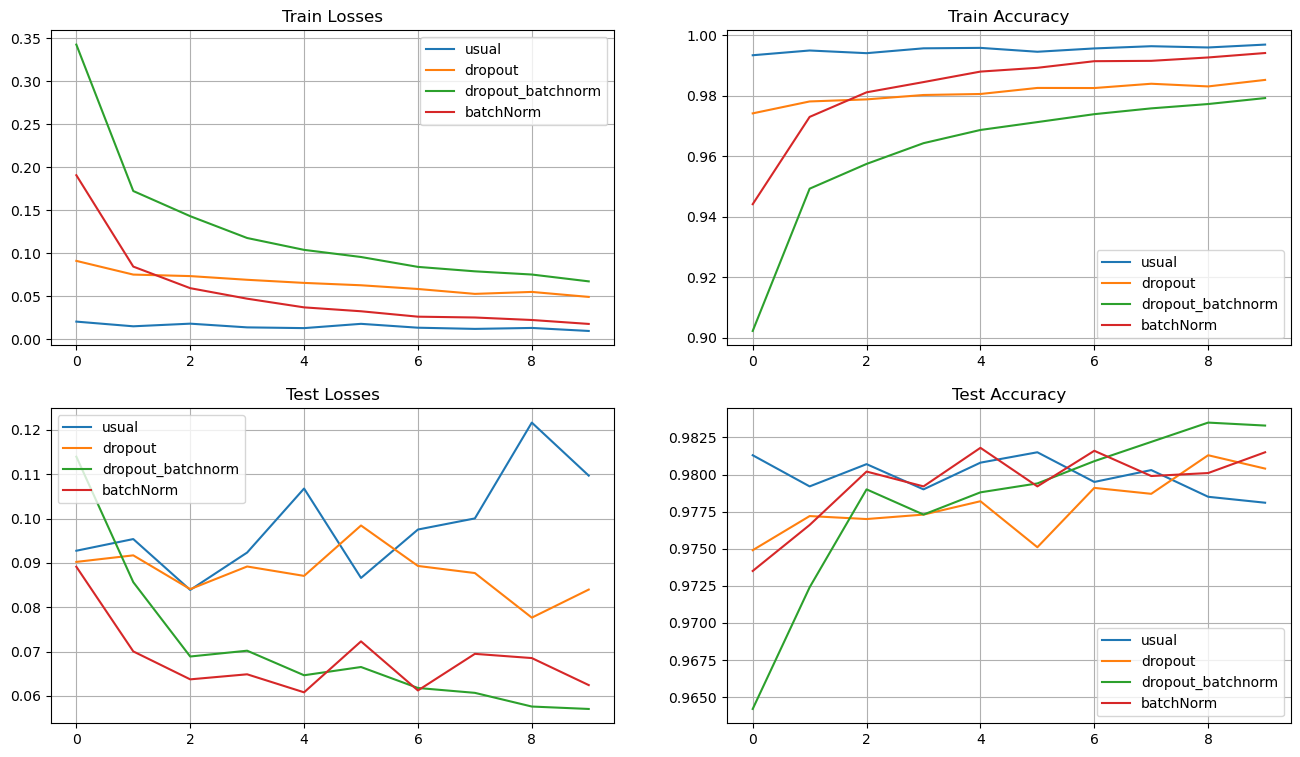

In [347]:
#### Сравните финальную точность
fig, ax = plt.subplots(2,2, figsize=(16, 9))

for k, values in search_loss.items():
    for i, val in enumerate(values.values()):
        nrow = i // 2
        ncol = i % 2
        ax[nrow, ncol].plot(val, label=k)
        ax[nrow, ncol].legend()
        ax[nrow, ncol].grid(True)

ax[0, 0].set_title('Train Losses')
ax[0, 1].set_title('Train Accuracy')
ax[1, 0].set_title('Test Losses')
ax[1, 1].set_title('Test Accuracy')

plt.show()

- Проанализируйте стабильность обучения
> Как мы видим, самые низкие потери и высокие значения на тренировочных данных (причем ведет себя очень стабильно( - usual layer. Она же дает самые высокие потери и низкую точность относительно других моделей на тестовой ввыборке (вела себя нестабильно)4
> 
> Dropout дает высокие и нестабильные потери, но стабильную точность
> 
> Самыми лучшими и стабильными относительно других на тестовой выборке были **Dropout + BatchNorm** и обычный **BatchNorm**. **Dropout + BatchNorm** был самым худшим по потерям и accuracy на train выборке, но вырвался вперед на test выборке, показав практически ***такой же результат***, как и на train выборке


## 3.2 Адаптивная регуляризация (10 баллов)

In [ ]:
# Реализуйте адаптивные техники:
# - Dropout с изменяющимся коэффициентом
# - BatchNorm с различными momentum
# - Комбинирование нескольких техник
# - Анализ влияния на разные слои сети